<a href="https://colab.research.google.com/github/OhJin-Soo/ktb_ai/blob/main/VIT_fintunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170M/170M [00:03<00:00, 47.2MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

[Epoch 1] Train Acc: 0.5176 Test Acc: 0.6442
[Epoch 2] Train Acc: 0.7447 Test Acc: 0.7551
[Epoch 3] Train Acc: 0.8135 Test Acc: 0.8148
[Epoch 4] Train Acc: 0.8530 Test Acc: 0.8035
[Epoch 5] Train Acc: 0.8813 Test Acc: 0.8303
[Epoch 6] Train Acc: 0.8995 Test Acc: 0.8525
[Epoch 7] Train Acc: 0.9168 Test Acc: 0.8576
[Epoch 8] Train Acc: 0.9306 Test Acc: 0.8512
[Epoch 9] Train Acc: 0.9374 Test Acc: 0.8507
[Epoch 10] Train Acc: 0.9460 Test Acc: 0.8585


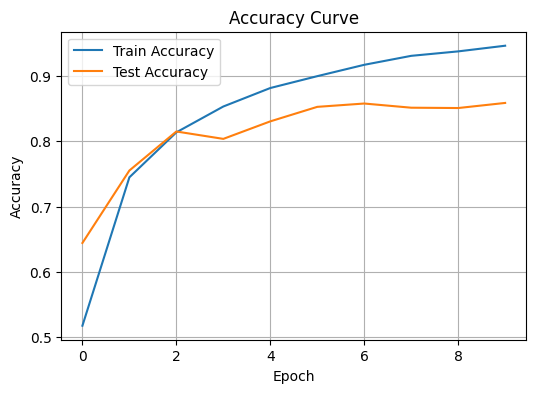

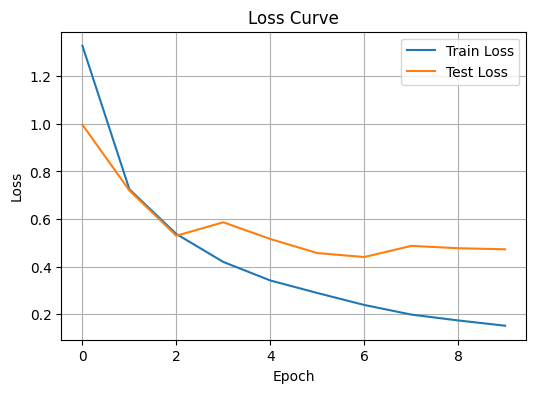

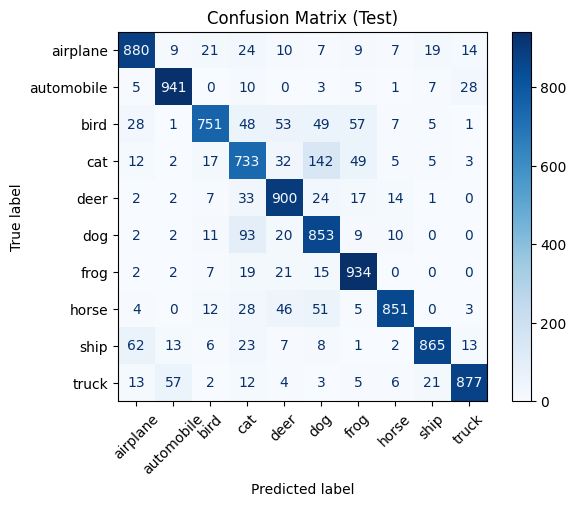

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
epochs = 10
lr = 3e-4

# CIFAR-10 데이터셋
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 🔥 Pretrained ViT 불러오기
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# ========================
#       Training Loop
# ========================
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ========================
    #      Evaluation
    # ========================
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    preds = []
    trues = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} Test Acc: {test_acc:.4f}")

# ========================
# 📈 성능 시각화
# ========================

# 🔹 정확도 그래프
plt.figure(figsize=(6,4))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Loss 그래프
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 혼동 행렬
cm = confusion_matrix(trues, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.show()
